In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV


In [12]:
# Load the dataset 
data = pd.read_csv('processed_data_Encoding.csv')

# Separate features and target
X = data.drop('y', axis=1)  # Features
y = data['y']  # Target


# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (36168, 49)
X_test shape: (9042, 49)


In [13]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Check the distribution of classes after resampling
print("Original class distribution (train):", y_train.value_counts())
print("Resampled class distribution (train):", y_train_res.value_counts())

Original class distribution (train): y
0    31972
1     4196
Name: count, dtype: int64
Resampled class distribution (train): y
0    31972
1    31972
Name: count, dtype: int64


In [14]:
# Specify numerical columns for scaling and PCA
numerical_cols = ['age', 'balance', 'campaign', 'previous','balance_no_previous'] 

# Apply scaling only to the specified numerical columns
scaler = StandardScaler()
X_train_scaled = X_train_res.copy()  # Copy to preserve other columns
X_test_scaled = X_test.copy()  # Copy to preserve other columns

# Scale only the numerical columns
X_train_scaled[numerical_cols] = scaler.fit_transform(X_train_res[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [15]:
# Apply PCA only to the scaled numerical columns
pca = PCA(n_components=0.95)  # Retain 95% variance
X_train_pca = pca.fit_transform(X_train_scaled[numerical_cols])
X_test_pca = pca.transform(X_test_scaled[numerical_cols])

# Drop original numerical columns from the data
X_train_scaled.drop(columns=numerical_cols, inplace=True)
X_test_scaled.drop(columns=numerical_cols, inplace=True)

# Add the PCA components to the scaled data
X_train_scaled = pd.DataFrame(X_train_scaled)
X_test_scaled = pd.DataFrame(X_test_scaled)

# Add PCA components as new columns
pca_columns = [f'PCA_{i+1}' for i in range(X_train_pca.shape[1])]
X_train_scaled[pca_columns] = X_train_pca
X_test_scaled[pca_columns] = X_test_pca

In [16]:
print(X_train_pca.shape)


(63944, 4)


In [17]:
X_test_scaled.shape

(9042, 48)

Random Forest - Training Accuracy: 0.9339734767921931
Random Forest - Test Accuracy: 0.8779031187790312
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      7949
           1       0.49      0.39      0.44      1093

    accuracy                           0.88      9042
   macro avg       0.71      0.67      0.68      9042
weighted avg       0.87      0.88      0.87      9042



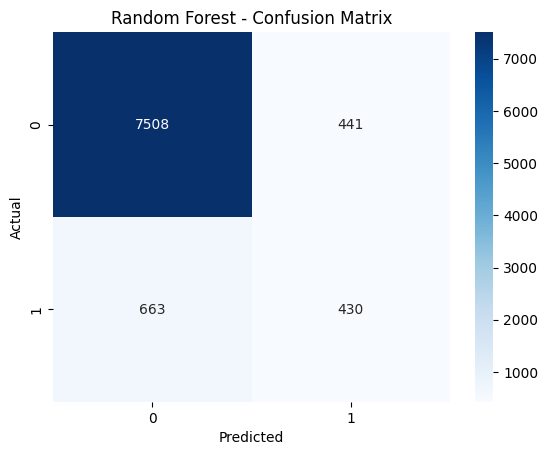

In [18]:
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=20, 
    min_samples_split=10, 
    min_samples_leaf=4, 
    class_weight='balanced',
    random_state=42
)
# {'class_weight': 'balanced_subsample', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

# rf_model = RandomForestClassifier(random_state=42)


rf_model.fit(X_train_scaled, y_train_res)

# Make predictions
rf_y_pred_train = rf_model.predict(X_train_scaled)
rf_y_pred_test = rf_model.predict(X_test_scaled)


# # Predict probabilities
# y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# # Choose a new threshold
# threshold = 0.4
# rf_y_pred_test = (y_pred_proba >= threshold).astype(int)

# Evaluate Model
print("Random Forest - Training Accuracy:", accuracy_score(y_train_res, rf_y_pred_train))
print("Random Forest - Test Accuracy:", accuracy_score(y_test, rf_y_pred_test))
print("Random Forest - Classification Report:")
print(classification_report(y_test, rf_y_pred_test))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, rf_y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [19]:
# Get predicted probabilities for the positive class
y_pred_prob = rf_model.predict_proba(X_test_scaled)[:, 1]

from sklearn.metrics import roc_auc_score

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.7868593205748863


# Tunning

In [20]:
# from sklearn.ensemble import RandomForestClassifier
# rf_model = RandomForestClassifier(random_state=42)

# # Define parameter grid for GridSearchCV
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'class_weight': ['balanced', 'balanced_subsample']
# }

# # param_grid = {
# #     'n_estimators': [100, 200, 300],           # Number of trees
# #     'max_depth': [10, 15, 20, None],           # Max depth of the trees
# #     'min_samples_split': [2, 5, 10],           # Minimum samples to split a node
# #     'min_samples_leaf': [1, 2, 4],             # Minimum samples per leaf
# #     'max_samples': [0.8, 1.0],                 # Fraction of samples to train each tree (80% or 100%)
# #     'class_weight': ['balanced_subsample'],    # Balanced weights for each bootstrap sample
# # }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='f1', verbose=2, n_jobs=-1)

# grid_search.fit(X_train_scaled, y_train_res)

# # Best parameters
# print("Best Parameters:", grid_search.best_params_)

# # Get the best model from GridSearchCV
# best_rf_model = grid_search.best_estimator_

# # Make predictions with the tuned model
# rf_tune_y_pred_train = best_rf_model.predict(X_train_scaled)
# rf_tune_y_pred_test = best_rf_model.predict(X_test_scaled)

# # Evaluate tuned model
# print("Random Forest Post-Tuning - Training Accuracy:", accuracy_score(y_train_res, rf_tune_y_pred_train))
# print("Random Forest Post-Tuning - Test Accuracy:", accuracy_score(y_test, rf_tune_y_pred_test))
# print("Random Forest Post-Tuning - Classification Report:")
# print(classification_report(y_test, rf_tune_y_pred_test))

# # Confusion Matrix for tuned model
# conf_matrix = confusion_matrix(y_test, rf_tune_y_pred_test)
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
# plt.title("Random Forest - Confusion Matrix")
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.show()

In [21]:
# # Get predicted probabilities for the positive class
# y_pred_prob = best_rf_model.predict_proba(X_test_scaled)[:, 1]

# from sklearn.metrics import roc_auc_score

# # Calculate ROC-AUC score
# roc_auc = roc_auc_score(y_test, y_pred_prob)
# print("ROC-AUC Score:", roc_auc)

In [22]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve

# # Get ROC curve data
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# # Plot the ROC curve
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (no discrimination)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend(loc='lower right')
# plt.show()
